# Exercise 26 - Neural Network Ansatz on Optimization Benchmarks
### Task
Compare a linear and neural network ansatz for different optimization benchmark functions (rosenbrock, rastrigrin, ackley, levy) using six different optimizers (steepest descent, steepest descent with momentum, adagrad, rmsprop, adam, lbfgs)

### Learning goals
- Familiarize yourself with the syntax of the neural network ansatz for optimization problems
- Understand how and when a neural network ansatz becomes beneficial for an optimization problem

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import torch
from torch.autograd import grad

## Select benchmark function, optimizer, and hyperparameters

**benchmark function**

In [33]:
benchmark = "rosenbrock"
#benchmark = "rastrigrin" 
#benchmark = "ackley" 
#benchmark = "levy" 

**optimizer**

In [34]:
#selectOptimizer = 'steepestDescent'
#selectOptimizer = 'steepestDescentWithMomentum' 
#selectOptimizer = 'adagrad' 
#selectOptimizer = 'rmsprop' 
selectOptimizer = 'adam'
#selectOptimizer = 'lbfgs'

**hyperparameters**

In [35]:
initialGuess = torch.tensor([[3, 3]])
lrTuningEpochs = 30
gridPoints = 50
epochs = 300
neurons = 50
layers = 1

## Neural network definition

In [36]:
class FNN(torch.nn.Module):
    def __init__(self, neurons, layers, y0, x0, kaiming=True):
        super().__init__()

        self.layers = layers

        self.linear1 = torch.nn.Linear(10, neurons)
        self.linear2 = torch.nn.ModuleList()
        for i in range(self.layers):
            self.linear2.append(torch.nn.Linear(neurons, neurons))
        self.linear3 = torch.nn.Linear(neurons, 2)
        self.activation = torch.nn.LeakyReLU(inplace=True)

        if kaiming == True:
            torch.nn.init.kaiming_uniform_(self.linear1.weight, nonlinearity='leaky_relu')
            torch.nn.init.constant_(self.linear1.bias, 0)
            for i in range(self.layers):
                torch.nn.init.kaiming_uniform_(self.linear2[i].weight, nonlinearity='leaky_relu')
                torch.nn.init.constant_(self.linear2[i].bias, 0)
            torch.nn.init.kaiming_uniform_(self.linear3.weight, nonlinearity='leaky_relu')
            torch.nn.init.constant_(self.linear3.bias, 0)

        # adjust initial guess   
        self.adjust = 0
        with torch.no_grad():
            y0Pred = self.forward(x0)
            self.adjust = y0Pred - y0

    def forward(self, x):
        y = self.activation(self.linear1(x))
        for i in range(self.layers):
            y = self.activation(self.linear2[i](y))
        y = self.linear3(y)
        return y - self.adjust


class Linear(torch.nn.Module):
    def __init__(self, y0):
        super().__init__()

        self.linear = torch.nn.Linear(1, 2, bias=False)
        self.linear.weight.data *= 0
        self.y0 = y0.detach()

    def forward(self, x):
        y = self.linear(torch.tensor([[1.]])) + self.y0
        return y

## Benchmark selection and derivatives

In [37]:
if benchmark == "rosenbrock":
    f = lambda y: 100 * (y[:, 1:2] - y[:, 0:1] ** 2) ** 2 + (1 - y[:, 0:1]) ** 2
elif benchmark == "rastrigrin":
    f = lambda y: 20 + y[:, 0:1] ** 2 - 10 * torch.cos(2 * np.pi * y[:, 0:1]) + y[:, 1:2] ** 2 - 10 * torch.cos(
        2 * np.pi * y[:, 1:2])
elif benchmark == "ackley":
    f = lambda y: - 20 * torch.exp(-0.2 * torch.sqrt(0.5 * (y[:, 0:1] ** 2 + y[:, 1:2] ** 2))) \
                  - torch.exp(0.5 * (torch.cos(2 * np.pi * y[:, 0:1]) + torch.cos(2 * np.pi * y[:, 1:2]))) + np.exp(
        1) + 20
elif benchmark == "levy":
    f = lambda y: torch.sin(3 * np.pi * (y[:, 0:1] + 1)) ** 2 + ((y[:, 0:1] + 1) - 1) ** 2 * (
            1 + torch.sin(3 * np.pi * (y[:, 1:2] + 1)) ** 2) \
                  + ((y[:, 1:2] - 1) + 1) ** 2 * (1 + torch.sin(2 * np.pi * (y[:, 1:2] + 1)) ** 2)

In [38]:
def dfdy(y):
    y0 = y[:, 0:1].detach()
    y1 = y[:, 1:2].detach()
    y0.requires_grad = True
    y1.requires_grad = True

    z = f(torch.cat((y0, y1), 1))

    dfdy0 = grad(z, y0, torch.ones_like(z), retain_graph=True)[0]
    dfdy1 = grad(z, y1, torch.ones_like(z))[0]

    return torch.cat((dfdy0, dfdy1), 1)


def getInverseHessian(y):
    return torch.linalg.inv(torch.autograd.functional.hessian(f, y)[0, :, 0, :]).detach()

## Training algorithm and learning rate tuning

In [39]:
def trainModel(model, xInput, lr, epochs, keepModel=False, selectOptimizer='adam'):
    torch.save(model.state_dict(), "tempModel")
    if selectOptimizer == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif selectOptimizer == 'steepestDescent':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    elif selectOptimizer == 'lbfgs':
        optimizer = torch.optim.LBFGS(model.parameters(), lr=lr)
    elif selectOptimizer == 'steepestDescentWithMomentum':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif selectOptimizer == 'rmsprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    elif selectOptimizer == 'adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)
    yHistory = np.zeros((epochs, 2))
    zHistory = np.zeros((epochs, 1))
    for epoch in range(epochs):
        def closure():
            optimizer.zero_grad()
            y = model(xInput)
            cost = f(y)
            cost.backward()
            return cost

        with torch.no_grad():
            y = model(xInput)
            yHistory[epoch] = y.detach()[0]
            zHistory[epoch] = f(y).detach()[0, 0]
            optimizer.step(closure)

    if keepModel == False:
        model.load_state_dict(torch.load("tempModel", weights_only=True))
    return yHistory, zHistory

In [40]:
def gridSearchForLr(model, xInput, epochs, gridPoints=10, selectOptimizer='adam'):
    if selectOptimizer == 'adam':
        lrs = np.logspace(-2, 0, gridPoints)
    elif selectOptimizer == 'steepestDescent':
        lrs = np.logspace(-6, -3, gridPoints)
    elif selectOptimizer == 'lbfgs':
        lrs = np.logspace(-2, 1, gridPoints)
    elif selectOptimizer == 'rmsprop':
        lrs = np.logspace(-4, 0, gridPoints)  # not tuned
    elif selectOptimizer == 'adagrad':
        lrs = np.logspace(-2, 1, gridPoints)
    elif selectOptimizer == 'steepestDescentWithMomentum':
        lrs = np.logspace(-6, -4, gridPoints)
    costs = np.zeros_like(lrs)
    for i, lr in enumerate(lrs):
        costs[i] = trainModel(model, xInput, lr, epochs, selectOptimizer=selectOptimizer)[1][-1]
    return lrs[np.nanargmin(costs)]

## Model initialization 

In [41]:
xInput = torch.rand((1, 10)) * 2 - 1

**linear ansatz**

In [42]:
model = Linear(initialGuess)
lr = gridSearchForLr(model, xInput, lrTuningEpochs, gridPoints, selectOptimizer=selectOptimizer)

**neural network ansatz**

In [43]:
modelNN = FNN(neurons, layers, initialGuess, xInput)
lrNN = gridSearchForLr(modelNN, xInput, lrTuningEpochs, gridPoints, selectOptimizer=selectOptimizer)

## Model training

In [44]:
yHistoryLinear, zHistoryLinear = trainModel(model, xInput, lr, epochs, selectOptimizer=selectOptimizer)
yHistoryNN, zHistoryNN = trainModel(modelNN, xInput, lrNN, epochs, selectOptimizer=selectOptimizer)

## Post-processing

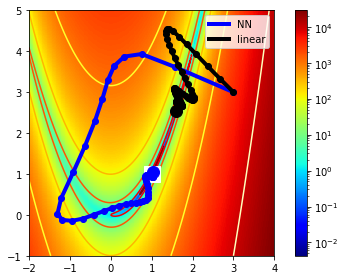

In [45]:
if benchmark == 'rosenbrock':
    plotRangex = [-2, 4]
    plotRangey = [-1, 5]
else:
    plotRangex = [-3.5, 3.5]
    plotRangey = [-3.5, 3.5]

x_ = torch.linspace(plotRangex[0], plotRangex[1], 300)
y_ = torch.linspace(plotRangey[0], plotRangey[1], 300)
x_, y_ = torch.meshgrid(x_, y_, indexing='ij')
y = torch.reshape(torch.cat((x_.unsqueeze(2), y_.unsqueeze(2)), 2), (300 * 300, 2))
z = torch.reshape(f(y), (300, 300))

fig, ax = plt.subplots()
if benchmark == 'rosenbrock':
    norm = colors.LogNorm()
else:
    norm = colors.Normalize()  # default
cp = ax.pcolormesh(x_, y_, z, norm=norm, cmap=plt.cm.jet, shading='auto')
ax.contour(x_, y_, z, norm=norm, cmap=plt.cm.hot)
plt.gca().set_aspect("equal", adjustable="box")

if benchmark == 'rosenbrock':
    ax.plot(1, 1, 'ws', markersize=16)  # optimum
else:
    ax.plot(0, 0, 'ws', markersize=16)  # optimum

ax.plot(yHistoryNN[:, 0], yHistoryNN[:, 1], '.', color='b', markersize=12)  # NN path
ax.plot(yHistoryNN[:, 0], yHistoryNN[:, 1], color='b', linewidth=4, label='NN')  # NN path
ax.plot(yHistoryNN[-1, 0], yHistoryNN[-1, 1], 'o', color='b', markersize=12)

ax.plot(yHistoryLinear[:, 0], yHistoryLinear[:, 1], 'k.', markersize=12)  # linear path
ax.plot(yHistoryLinear[:, 0], yHistoryLinear[:, 1], 'k', linewidth=4, label='linear')  # linear path
ax.plot(yHistoryLinear[-1, 0], yHistoryLinear[-1, 1], 'ko', markersize=12)

ax.set_xlim(plotRangex[0], plotRangex[1])
ax.set_ylim(plotRangey[0], plotRangey[1])

ax.legend()
fig.colorbar(cp)
fig.tight_layout()
plt.show()

## Who was better?

In [46]:
if f(torch.from_numpy(yHistoryNN[-2:-1, :]))[0, 0] < f(torch.from_numpy(yHistoryLinear[-2:-1, :]))[0, 0]:
    print("NN outperformed Linear")
else:
    print("Linear outperformed NN")

NN outperformed Linear


In [47]:
f(torch.from_numpy(yHistoryNN[-2:-1, :]))[0, 0]

tensor(0.0005, dtype=torch.float64)

In [48]:
f(torch.from_numpy(yHistoryLinear[-2:-1, :]))[0, 0]

tensor(0.3544, dtype=torch.float64)